# Paper TMDs

In [1]:
### IMPORTS ###
folder0 = ''

import os
import sys
sys.path.append(folder0)
from Func_Floquet_classes import *
from matplotlib import cm
from IPython.display import Math
from sympy.interactive import printing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
## Personalized plots
from matplotlib.lines import Line2D
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm,amsmath,amsfonts,amssymb,bbold}"
from Func_general import *
plotParams('paper')
%matplotlib inline

## Units conversion
import scipy.constants as sconst
from sympy.physics.quantum import TensorProduct as TP

###############################
### TMDs Hamiltonian Parameters:

parameters_TMDs={'a':3.193,'Delta':1.66,'t':1.10,'Lambda':0.15/2,'tau':1,'W':1}
parameters_Polarization={'phi':0,'epsilon':1, 'chi':np.pi/4}
pTMDs = SimpleNamespace(**parameters_TMDs, **parameters_Polarization)


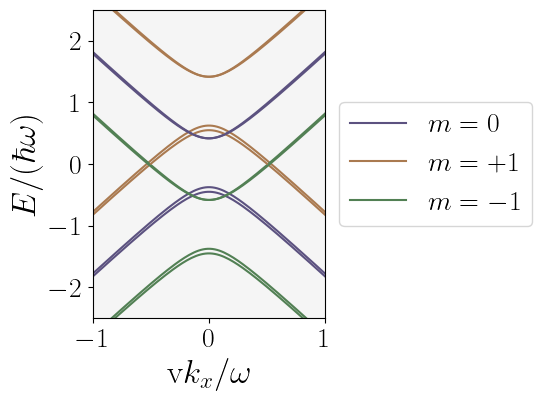

In [2]:
## Schematic plot of the bands:
# Define parameters
a, t, tau, Delta, Lambda, W = 3.193, 1.10, 1, 1.66, 0.15/2, 1/2 
k_x, k_y = sp.symbols('k_x k_y', real=True)

s0 = sp.Matrix([[1, 0], [0, 1]])
sx = sp.Matrix([[0, 1], [1, 0]])
sy = sp.Matrix([[0, -sp.I], [sp.I, 0]])
sz = sp.Matrix([[1, 0], [0, -1]])

h0_k = (a * t * (tau * k_x * TP(sx, s0) + k_y * TP(sy, s0)) +
        Delta / 2 * TP(sz, s0) -
        Lambda * tau / 2 * (TP(sz, sz) - TP(s0, sz))) * W

eigenvalues = sp.Matrix(list(h0_k.eigenvals().keys()))
eigenvalues_funcs = [sp.lambdify((k_x, k_y), ev) for ev in eigenvalues]


kx_vals = np.linspace(-2, 2, 200)
ky_val = 0 

eigenenergies = []
for func in eigenvalues_funcs:
    eigenenergies.append([func(kx, ky_val) for kx in kx_vals])


fig, ax = plt.subplots(figsize=(3, 4)) 
ax.set_facecolor('#F5F5F5')  

for band in eigenenergies:
    ax.plot(kx_vals, np.array(band), color='#5C5280' , label=r'$m=0$')     
    ax.plot(kx_vals, np.array(band)+1, color='#AA7A50', label=r'$m=+1$')      
    ax.plot(kx_vals, np.array(band)-1, color='#528054', label=r'$m=-1$')      


line_original = mlines.Line2D([], [], color='#5C5280' , label=r'$m=0$')
line_mas = mlines.Line2D([], [], color='#AA7A50', label=r'$m=+1$')
line_menos = mlines.Line2D([], [], color='#528054', label=r'$m=-1$')

ax.set_xlabel(r'$\mathrm{v}k_x/\omega$')
ax.set_ylabel(r'$E/(\hbar \omega)$')
ax.set_ylim([-4, 4])


ax.legend(handles=[line_original, line_mas, line_menos],loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(r'$\mathrm{v}k_x/\omega$')
ax.set_ylabel(r'$E/(\hbar \omega)$')
ax.set_ylim([-2.5, 2.5])
ax.set_xlim([-1, 1])

plt.show()
plt.close()

## Floquet Hamiltonian

In [3]:
ham_symbols = sp.symbols("a Delta t Lambda tau phi chi epsilon W", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

hTMDs = Hamiltonian(
    h0_k = (a*t*(tau*k_x*(TP(sx,s0))+k_y*TP(sy,s0))+Delta/2*TP(sz,s0)-Lambda*tau/2*(TP(sz,sz)-TP(s0,sz)))* W,
    Axt=A_x * sp.cos(2 * sp.pi / T_p * t_sp + phi)/(sp.sqrt(1+epsilon**2)),
    Ayt=A_y * sp.sin(2 * sp.pi / T_p * t_sp + phi)*epsilon/(sp.sqrt(1+epsilon**2)),
    ham_symbols=ham_symbols)

par_var = {'k_x': None, 'k_y': None, 'A_x': None, 'A_y': None}
par_fix = {'a' : pTMDs.a, 't': pTMDs.t, 'tau': pTMDs.tau, 'Lambda': pTMDs.Lambda,'Delta':  pTMDs.Delta, 'phi':pTMDs.phi,'chi':pTMDs.chi,'epsilon':pTMDs.epsilon,'W':pTMDs.W}
par_fix_b = {'a' : pTMDs.a, 't': pTMDs.t, 'tau': -pTMDs.tau, 'Lambda': pTMDs.Lambda,'Delta': pTMDs.Delta, 'phi':pTMDs.phi,'chi':pTMDs.chi,'epsilon':pTMDs.epsilon,'W':pTMDs.W}

hTMDsFF = Hamiltonian_FloquetFourier(hTMDs ,par_var, par_fix =  par_fix,  N = 10)
hTMDsFF_b = Hamiltonian_FloquetFourier(hTMDs ,par_var, par_fix =  par_fix_b,  N = 10)

from IPython.display import Math
from sympy.interactive import printing

Math('{}'.format(printing.default_latex(hTMDs.fourier_elements(1))))

<IPython.core.display.Math object>

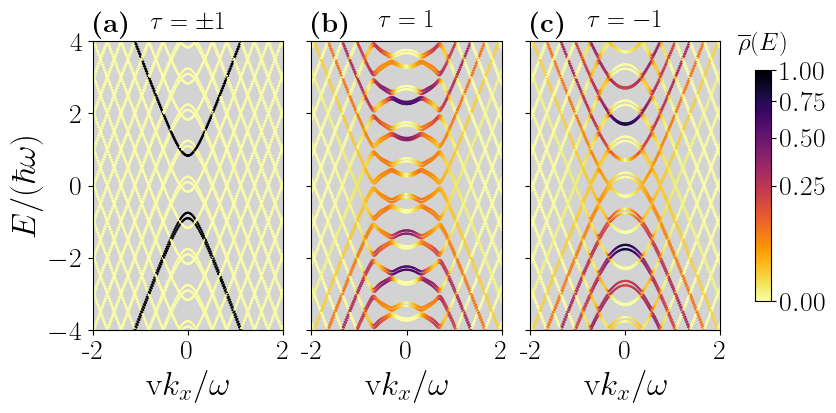

In [14]:
momentax = np.linspace(-2, 2, 201) 
fig, axs = plt.subplots(1, 3, figsize=(12 * 0.75, 5*0.75), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.15) 

Aval = 0.5 * np.sqrt(2)

par = {'k_y': 0., 'A_x': 0.001, 'A_y': 0.001}
obs = ObservablesFF(hTMDsFF, 'k_x', momentax, params=par)
out = obs.timeAveragedDOS(ax=axs[0], Nmax=10, cbar=False, fig=fig, axs=axs)
axs[0].set_title(r'$\tau=\pm 1$', fontsize=18, pad=10)

# τ = 1
par = {'k_y': 0., 'A_x': Aval, 'A_y': Aval}
obs = ObservablesFF(hTMDsFF, 'k_x', momentax, params=par)
out = obs.timeAveragedDOS(ax=axs[1], Nmax=10, cbar=False, fig=fig, axs=axs)
axs[1].set_title(r'$\tau = 1$', fontsize=18, pad=10)
axs[1].set(ylabel=None)

# τ = -1
par = {'k_y': 0., 'A_x': Aval, 'A_y': Aval}
obs = ObservablesFF(hTMDsFF_b, 'k_x', momentax, params=par)
out = obs.timeAveragedDOS(ax=axs[2], Nmax=10, cbar=True, fig=fig, axs=axs, pad=0.05)
axs[2].set_title(r'$\tau = -1$', fontsize=18, pad=10)
axs[2].set(ylabel=None)

axs[0].set(ylabel=r'$E/(\hbar \omega)$', ylim=(-4, 4), xlim=(-2, 2))
for ax in axs:
    ax.set(xlabel=r'$\mathrm{v}k_x/\omega$')
    ax.set(xticks=[-2, 0, 2], xticklabels=[-2, 0, 2])

createletters(axs, coord=[0., 1.03])

fig

## t-t' formalism

In [4]:
def TP(mat1, mat2):
    """Compute the Kronecker (tensor) product of two matrices."""
    return sp.Matrix(sp.kronecker_product(mat1, mat2))

parameters_TMDs={'a':3.193,'Delta':1.66,'t':1.10,'Lambda':0.15/2,'tau':1,'W':1/1}
pTMDs = SimpleNamespace(**parameters_TMDs)

par_var = {'k_x': None, 'k_y': None, 'A_x': None, 'A_y': None}
ham_symbols = sp.symbols("a t tau Lambda Delta phi chi mu_sp tau_sp W alpha", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)



par_fix = {'a' : pTMDs.a, 't': pTMDs.t, 'Lambda': pTMDs.Lambda,'Delta': pTMDs.Delta,
           'chi': np.pi/4, 'phi':0, 'T_p':1, 'W':pTMDs.W}
params_ham = {'k_x' : 0.01 ,'k_y' : 0.0, 'phi':0,'chi':np.pi/4}

hTMDs_pulse = Hamiltonian_ttp(
    h0_k = 
          W*( a*t*(tau*k_x*(TP(sx,s0))+k_y*TP(sy,s0))+Delta/2*TP(sz,s0)-Lambda*tau/2*(TP(sz,sz)-TP(s0,sz))),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.cos(2 * sp.pi / T_p * t_sp + phi)/(sp.sqrt(1+sp.tan(chi)**2)),
    Vyt= sp.sin(2 * sp.pi / T_p * t_sp + phi)*sp.tan(chi)/(sp.sqrt(1+sp.tan(chi)**2)), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 40) #Importat to add N large,  ## We reduce the number of Fourier replicas to speed up a bit the loop

##%%
calc = False
ts = np.linspace(1e-4, 7.1, 2200)
ks = np.arange(-2, 2, 0.05) + 1e-3  ## offset to avoid the numerical degenerancy at the DirP
Aval = 0.7
psi0band = 1

params_env = {'mu_sp' : 4., 'tau_sp' : .75 , 'A_x':Aval, 'A_y':Aval, 'A_z': 0.}

tau_valley = 1 ## Select the valley index for computations.

folderin = 'Data_ifs' if tau_valley == +1 else 'Data_ifs_tauNeg'
if calc:
    for kx in ks:
        params_ham = {'k_x': kx, 'k_y': 0.0, 'tau': tau_valley}

        name = folder0 + 'FigsPaper/{}/Ct_Ax{:.2f}_Ay{}_kx{:.4f}_ky{}.npz'.format(
            folderin, params_env['A_x'], params_env['A_y'], kx, params_ham['k_y'], )

        params_full = {**params_ham}
        solver_ifs = IFS_solver(hTMDs_pulse, ts, params_env, params_full, Nmax = 6)
        ct0, psitsol0 = solver_ifs.c_t(psi0band=0, tend=7., psi_t=True)
        ct1, psitsol1 = solver_ifs.c_t(psi0band=1, tend=7., psi_t=True)
        ct2, psitsol2 = solver_ifs.c_t(psi0band=2, tend=7., psi_t=True)
        ct3, psitsol3 = solver_ifs.c_t(psi0band=3, tend=7., psi_t=True)
        UsC= hTMDs_pulse.time_evolutionU(dict(**params_env, **params_ham, **par_fix), ts, steps = True)

        np.savez(name,
                 ts=ts, ct=np.array([ct0, ct1, ct2, ct3]),
                 psitsol=np.array([psitsol0, psitsol1, psitsol2, psitsol3]),
                 e0=nla.eigvalsh(solver_ifs.ham0),
                 UsC=UsC, eL=solver_ifs.eL, tagvec=solver_ifs.tag_fqlevels(),
                 indexCbase = solver_ifs.indexCbase)

else:

    def import_data(kx):
        params_ham = {'k_x': kx, 'k_y': 0.0}
        name = folder0 + 'FigsPaper/{}/Ct_Ax{:.2f}_Ay{}_kx{:.4f}_ky{}.npz'.format(
            folderin,params_env['A_x'], params_env['A_y'], kx, params_ham['k_y'], )
        return np.load(name)
    data= []
    for kx in ks:
        params_ham = {'k_x': kx, 'k_y': 0.0, }
        datai= import_data(kx)
        data.append({'tagvec' :datai['tagvec'], 'indexCbase' : datai['indexCbase'],
                     'eL': datai['eL'], 'ct' :datai['ct'][psi0band],
                     'psit': datai['psitsol'][psi0band]})
    ts = datai['ts']



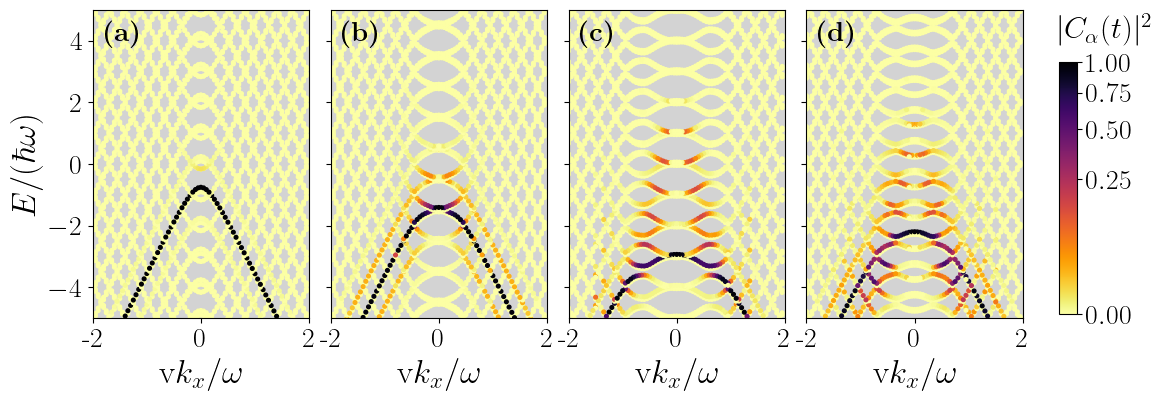

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(3 * 4, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.08)

# Selecting some time_indices to visualize the spectra. In this case indices are [0,1,3,4]
# to change valley index we need to select tau_valley in previous cell

t_sel = np.array([-2, -1, -0.2, 0, 0.6, 1., 2.]) + params_env['mu_sp']
selected_indices = [0, 1, 3, 4]
t_sel_selected = t_sel[selected_indices]
inds_t = [np.argmin(np.abs(ts - ti)) for ti in t_sel_selected]

cmap = mpl.colormaps['inferno_r']
norm = mpl.colors.PowerNorm(vmin=0, vmax=1, gamma=0.45)


for ti, ax in zip(inds_t, axs.ravel()):
    eL = np.array([datai['eL'][ti] for datai in data])
    ct_k = np.array([datai['ct'] for datai in data])
    indexCbase_k = np.array([datai['indexCbase'] for datai in data])
    col_k = np.abs(ct_k[:, ti]) ** 2
    ensL = np.array([eL[ki, indexCbase_k[ki]] for ki in range(len(data))])  

    for nband in range(len(indexCbase_k[0])):
        ks_flat = ks
        ensL_flat = ensL[:, nband]
        col_k_flat = col_k[:, nband]

        sorted_indices = np.argsort(col_k_flat)
        ks_sorted = ks_flat[sorted_indices]
        ensL_sorted = ensL_flat[sorted_indices]
        col_k_sorted = col_k_flat[sorted_indices]
        z1 = ax.scatter(ks_sorted, ensL_sorted, c=col_k_sorted, s=7, cmap=cmap, norm=norm)

    ax.set(facecolor='lightgrey')
    ax.set(xlim=(-2, 2), ylim=(-5, 5))

axs[0].set_ylabel(r'$E/(\hbar \omega)$')

for ax in axs:
    ax.set_xlabel(r'$\mathrm{v}k_x/\omega$')
    ax.set(xticks=[-2, 0, 2], xticklabels=[-2, 0, 2])

# Configurar la barra de color
cbar_pos = fig.add_axes([0.93, 0.12, 0.015, 0.63])  # [left, bottom, width, height]

cbar_ax = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                       ax=axs, pad=0.05, shrink=0.25, aspect=20, fraction=0.03, cax=cbar_pos)
cbar_ax.ax.set_title(r'$|C_\alpha(t)|^2$', fontsize=22, y=1.15, pad=-10, loc='left')

createletters(axs.ravel(), coord=[0.05, 0.9])

fig;


## Gamma // Chi // Phi dependance

In [11]:
parameters_TMDs={'a':3.193,'Delta':1.66,'t':1.10,'Lambda':0.15/2,'tau':1,'W':1}
parameters_Polarization={'chi':np.pi/4, 'phi':0}
pTMDs = SimpleNamespace(**parameters_TMDs, **parameters_Polarization)

params_ham = {'k_x' : 0.01 ,'k_y' : 0.0, 'phi':0, 'chi':np.pi/4}
par_fix = {'a' : pTMDs.a, 't': pTMDs.t, 'tau': pTMDs.tau, 'Lambda': pTMDs.Lambda,'Delta': pTMDs.Delta,'chi': pTMDs.chi,'phi': pTMDs.phi, 'T_p':1,'W':pTMDs.W}


ham_symbols = sp.symbols("a t tau Lambda Delta phi chi mu_sp tau_sp W alpha", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

hTMDs_pulse = Hamiltonian_ttp(
    h0_k = 
          W*( a*t*(tau*k_x*(TP(sx,s0))+k_y*TP(sy,s0))+Delta/2*TP(sz,s0)-Lambda*tau/2*(TP(sz,sz)-TP(s0,sz))),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.cos(2 * sp.pi / T_p * t_sp + phi)/(sp.sqrt(1+sp.tan(chi)**2)),
    Vyt= sp.sin(2 * sp.pi / T_p * t_sp + phi)*sp.tan(chi)/(sp.sqrt(1+sp.tan(chi)**2)), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 10) 

## Data Figure 2 ###
calc = False

psi0band, T = 0, 1.
ts = np.linspace(0, 8* T, 3000) + 1e-4
ki=0.2
chi = np.pi/4 
phi = 0
taus = [0.5,1,1.5]

if calc:
    solverL1 = []
    data  = []
    for tau in taus:
        params_env = {'mu_sp' : 4., 'tau_sp' : tau , 'A_x': 0.3, 'A_y':0.3, 'A_z': 0}
        params_ham = {'k_x' : ki, 'k_y' : 0.0, 'phi':phi, 'chi':chi}
        params_full = {**params_ham}
        solver_ki = IFS_solver(hTMDs_pulse, ts, params_env, params_full, Nmax = 5)
        params_env = {'mu_sp' : 4., 'tau_sp' : tau , 'A_x': 0.3, 'A_y': 0.3, 'A_z': 0}
        params_ham = {'k_x' : ki, 'k_y' : 0.0, 'phi':phi, 'chi':chi}
        UsC= hTMDs_pulse.time_evolutionU(dict(**params_env, **params_ham, **par_fix), ts, steps = True)
        ct, psitsol = solver_ki.c_t(psi0band=psi0band, tend=7.99, psi_t=True)
        
        ts_ct = ts[:len(ct)]
        data.append({'tagvec':solver_ki.tag_fqlevels(),
                       'indexCbase' : solver_ki.indexCbase,
                       'eL':solver_ki.eL, 'ct':ct, 'psit':psitsol,
                     'psiTDSE': UsC@psitsol[0], 'ts' : ts, 'ts_ct': ts_ct, **params_env, **params_ham})
        np.save(folder0+'FigsPaper/A_03', data)
else:
    data = np.load(folder0+'FigsPaper/A_03.npy', allow_pickle=True)

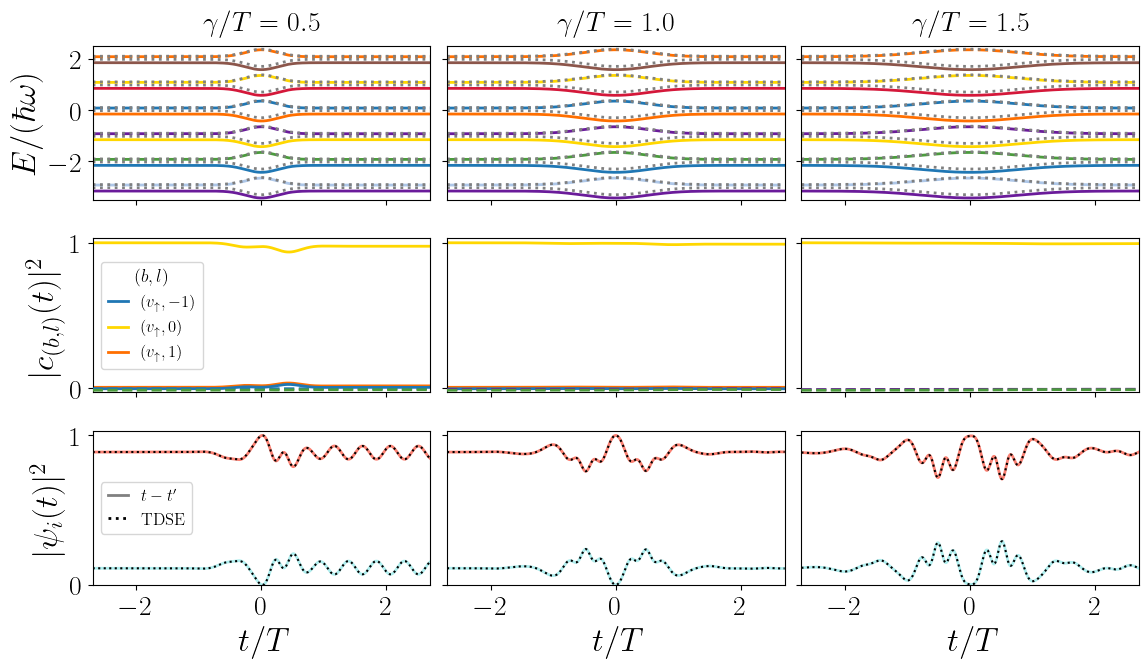

In [ ]:
fig, axsall = plt.subplots(3,3, figsize=(13.5, 7), sharex=True, sharey='row', height_ratios=[2, 2, 2])
plt.subplots_adjust(hspace=0.25, wspace=0.05)

custom_colors = [
    '#7f7f7f',  '#aec7e8',  '#4B9B3D', '#6A1B9A', '#1F77B4', '#FFD700',
    '#FF6F00',  '#D4183A', '#8C564B', '#8C564B', '#9467BD',  '#E377C2',
    '#1F77B4',  '#BCBD22', '#98DF8A', '#FF9896'
]

cmap = mpl.colors.ListedColormap(custom_colors)
bounds = np.arange(-5.5, 10.6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

def format_label(b, l):
    spin = '\\uparrow' if b % 2 == 0 else '\\downarrow'
    state = 'v' if b in [0, 1] else 'c'
    return f'$({state}_{spin},{l})$'

lines = [Line2D([0], [0], color='k', linewidth=2, linestyle=ls) for ls in ['-', '--',':','-.']]
lab_lines = ['$b = 0$', '$b = 1$','$b = 2$', '$b = 3$']

linespsit = [Line2D([0], [0], color=c, linewidth=2, linestyle=ls) for c, ls in zip(['grey', 'k'], ['-', ':'])]
lab_linespsit = ['$t-t^\\prime$', 'TDSE'] 

first_plot = True

for axs, datai in zip(axsall.T, data):
    for cti, i in enumerate(datai['indexCbase']):
        l, m = datai['tagvec'][i]
        ls = ['-', ':', '--', ':'][int(l)]
        color = 'gray' if ls == ':' else cmap(norm(m)) 
        label = format_label(int(l), int(m)) if (np.max(abs(datai['ct'][:, cti])) > 0.1) else None
        
        if np.max(datai['ct'][:, cti] ** 2) > 0.001:
            axs[1].plot(datai['ts_ct'] - 4, (np.abs(datai['ct'][:, cti]) ** 2) + 0.005 * m,
                        lw=2, c=color, zorder=-(m) + l, ls=ls, label=label)
        axs[0].plot(datai['ts'] - 4, datai['eL'][:, i], lw=2, c=color, ls=ls, label=label)

    axs[2].plot(datai['ts_ct'] - 4, np.abs(datai['psit'][:, 3]) ** 2, c='salmon', lw=2)
    axs[2].plot(datai['ts_ct'] - 4, np.abs(datai['psit'][:, 1]) ** 2, c='paleturquoise', lw=2)
    axs[2].plot(datai['ts'] - 4, np.abs(datai['psiTDSE'][:, 3]) ** 2, ls=':', c='k')
    axs[2].plot(datai['ts'] - 4, np.abs(datai['psiTDSE'][:, 1]) ** 2, ls=':', c='k')  

    if first_plot:
        axs[2].legend(linespsit, lab_linespsit, handlelength=1.2, fontsize=12, loc='center left')
        handles, labels = axs[1].get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        lg_col = axs[1].legend(handles, labels, fontsize=12, handlelength=1.2, ncols=1, loc='center left', title=r"$(b,l)$")
        lg_col.get_title().set_fontsize('13')
        first_plot = False  

for i, title in enumerate([r'$\gamma/T = 0.5 $', r'$\gamma/T = 1.0 $', r'$\gamma/T = 1.5 $']):
    axsall[0, i].set_title(title, y=1.05)

[ax.set(xlabel=r'$t/T$', xlim=(-4, 4)) for ax in axsall[-1]]

axsall[2, 0].set(ylabel=r'$|\psi_i(t)|^2$', xlabel='$t$', ylim=(0, 1.03))
axsall[0, 0].set(ylabel=r'$E/(\hbar \omega)$', xlabel='', ylim=(-3.5, 2.5), yticks=[-2,0, 2])
axsall[1, 0].set(ylabel=r'$|c_{(b,l)}(t)|^2$', xlabel='', ylim=(-0.03, 1.03))
[ax.set(xlabel=r'$t/T$', xlim=(-2.7, 2.7)) for ax in axsall[-1]]

plt.close()

fig

In [4]:
from tqdm import tqdm

psi0band, T = 0, 1.
ts = np.linspace(0, 8*T, 6000) + 1e-4
calc = False
ki = 0.2
N_chis = 70
chi_s = np.linspace(-np.pi/4, np.pi/4, N_chis)
tau = 1.0
params_env = {'mu_sp': 4., 'tau_sp': tau, 'A_x': 0.5*np.sqrt(2), 'A_y': 0.5*np.sqrt(2), 'A_z': 0}


def format_label(b, l):
    spin = '\\uparrow' if b % 2 == 0 else '\\downarrow'
    state = 'v' if b in [0, 1] else 'c'
    return f'$({state}_{spin},{int(l)})$'

if calc:
    dataA = []
    dataB = []
    for i, beta in enumerate(tqdm(chi_s, desc='',dynamic_ncols=False)):
        params_ham = {'k_x': ki, 'k_y': 0.0, 'chi': beta, 'phi':0}
        solver_ki = IFS_solver(hTMDs_pulse, ts, params_env, params_ham, Nmax=5)
        ct = solver_ki.c_t(psi0band=psi0band, tend=7.99, psi_t=False)
        tagvec = solver_ki.tag_fqlevels()  # Returns (b,l)
        indexCbase = solver_ki.indexCbase  
        
        # Last ct
        ct_end = ct[-1]
        
        # Saving ct[-1]
        ct_info = []
        for cti, idx in enumerate(indexCbase):
            b, l = tagvec[idx]
            label = format_label(b, l)
            ct_val = ct_end[cti]
            ct_info.append({
                'b': b,
                'l': l,
                'label': label,
                'ct_end': ct_val
            })
        dataA.append({ 'chi': beta, 'ct_info': ct_info })
        ct_end = ct[len(ct)//2]
        # Save ct[half]
        ct_info = []
        for cti, idx in enumerate(indexCbase):
            b, l = tagvec[idx]
            label = format_label(b, l)
            ct_val = ct_end[cti]
            ct_info.append({
                'b': b,
                'l': l,
                'label': label,
                'ct_end': ct_val
            })
        dataB.append({'chi': beta,'ct_info': ct_info
        })
    
    # Guardar datos en archivo
    np.save(folder0+'FigsPaper/dataFigChi_A', dataA)
    np.save(folder0+'FigsPaper/dataFigChi_B', dataB)

else:
    data_a = np.load('FigsPaper/dataFigChi_A_piSAME.npy', allow_pickle=True)
    data_b = np.load('FigsPaper/dataFigChi_B_piSAME.npy', allow_pickle=True)


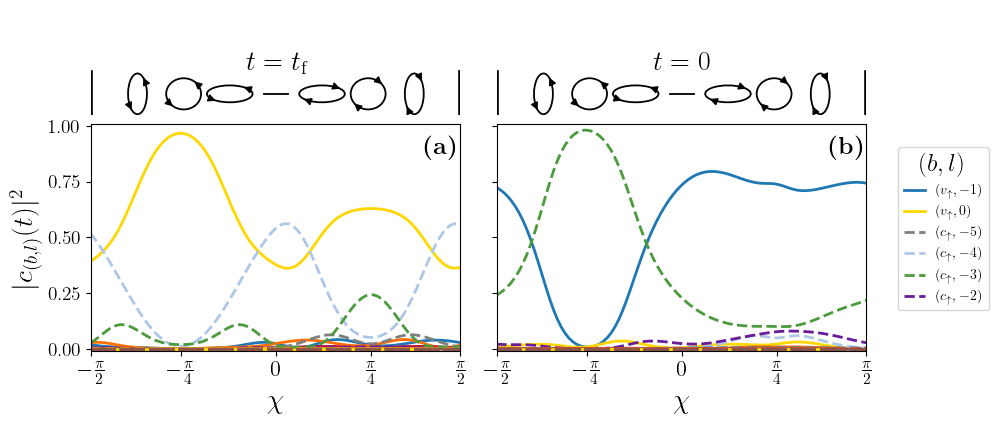

In [12]:
import matplotlib.patches as patches

custom_colors = ['#7f7f7f',  '#aec7e8',  '#4B9B3D', '#6A1B9A', '#1F77B4', '#FFD700', '#FF6F00', '#D4183A', '#8C564B',
                 '#8C564B', '#9467BD', '#E377C2', '#1F77B4', '#BCBD22', '#98DF8A', '#FF9896']

min_l = -5 
max_l = 10 
bounds = np.arange(min_l - 0.5, max_l + 1.5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5*2, 3.5), sharey=True)
plt.subplots_adjust(wspace=0.1)
axes = [ax1, ax2]
datasets = [data_a, data_b]
titles = [r'$t=t_{\text{f}}$', r'$t=0$']

fig.subplots_adjust(top=0.75, bottom=0.1)
pos1 = ax1.get_position()
pos2 = ax2.get_position()
ellipse_axes_height = 0.3 
ellipse_axes_bottom = 0.775 
ax1_ellipse = fig.add_axes([pos1.x0, ellipse_axes_bottom, pos1.width, ellipse_axes_height])
ax2_ellipse = fig.add_axes([pos2.x0, ellipse_axes_bottom, pos2.width, ellipse_axes_height])
ellipse_axes = [ax1_ellipse, ax2_ellipse]


def draw_polarization(ax, chi, x_pos, y_pos=0.5, size=0.5, arrow_size=11):
    color = 'black'
    lw = 1.3

    
    if np.isclose(chi, 0):
        ax.plot([x_pos - size/4, x_pos + size/4], [y_pos, y_pos], color=color, lw=lw)
    elif np.isclose(chi, np.pi/2):
        ax.plot([x_pos, x_pos], [y_pos - size/2, y_pos + size/2], color=color, lw=2*lw)
    elif np.isclose(chi, -np.pi/2): 
        ax.plot([x_pos, x_pos], [y_pos - size/2, y_pos + size/2], color=color, lw=2*lw)
    else:
        width = size * np.abs(np.cos(chi))
        height = size * np.abs(np.sin(chi))
        ellipse = patches.Ellipse((x_pos, y_pos), width=width, height=height,
                                  angle=0, fill=False, color=color, lw=lw)
        ax.add_patch(ellipse)


        for ang in [np.pi+np.pi/4, np.pi/4]:  
            arrow_angle = ang 

        
            arrow_x = x_pos + (width / 2) * np.cos(arrow_angle)
            arrow_y = y_pos + (height / 2) * np.sin(arrow_angle)
    
            
            dx = -(width / 2) * np.sin(arrow_angle)
            dy = (height / 2) * np.cos(arrow_angle)
    
            
            if chi > 0:
                dx *= -1
                dy *= -1
    
            norm = np.sqrt(dx**2 + dy**2)
            if norm > 0:
               scale = 0.1
               arrow = patches.FancyArrowPatch((arrow_x - dx/norm * scale*0.2 , arrow_y - dy/norm* scale*0.2), 
                                               (arrow_x + dx/norm * scale*0.2 , arrow_y + dy/norm* scale*0.2), 
                                               arrowstyle='-|>', mutation_scale=arrow_size, color=color, lw=1)
               ax.add_patch(arrow)

chi_values_vis = np.array([-np.pi/2, -3*np.pi/8, -np.pi/4, -np.pi/8, 0,
                           np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])
chi_labels_vis = [r'$-\frac{\pi}{2}$', r'$-\frac{3\pi}{8}$', r'$-\frac{\pi}{4}$', r'$-\frac{\pi}{8}$',
                   r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$']


ellipse_size = 0.42 
ellipse_y_center = 0.2 
label_y_pos = 0.4 

for ax_e in ellipse_axes:
    ax_e.set_xlim(-np.pi/2, np.pi/2) 
    ax_e.set_ylim(0, 1)             
    ax_e.axis('off')                

    for chi_val, chi_lab in zip(chi_values_vis, chi_labels_vis):
        draw_polarization(ax_e, chi_val, x_pos=chi_val, y_pos=ellipse_y_center, size=ellipse_size)


def process_data(data):
    all_bl = []
    for d in data:
        for info in d['ct_info']:
            bl = (info['b'], info['l'])
            if bl not in all_bl:
                all_bl.append(bl)
    all_bl.sort(key=lambda x: (x[0], x[1]))
    return all_bl

all_bl_a = process_data(data_a)
all_bl_b = process_data(data_b)
combined_bl = list(set(all_bl_a + all_bl_b))
combined_bl.sort(key=lambda x: (x[0], x[1]))


def format_label(b, l):
    spin = '\\uparrow' if b % 2 == 0 else '\\downarrow'
    state = 'v' if b in [0, 1] else 'c' 
    return f'$({state}_{{{spin}}},{int(l)})$'


def get_line_style(b):
    styles = ['-', ':', '--', '-.']
    return styles[int(b) % len(styles)]


legend_handles = {}
for ax, data, title_main in zip(axes, datasets, titles):
    processed_bl_for_this_plot = process_data(data) 
    for (b, l) in combined_bl: 
        chis_plot = []
        cts_plot = []
        present_in_this_data = False 
        for d in data:
            chi = d['chi']
            found_info = False
            for info in d['ct_info']:
                if info['b'] == b and info['l'] == l:
                    chis_plot.append(chi)
                    ct_val = info.get('ct_end', 0)
                    try:
                       cts_plot.append(np.abs(ct_val)**2)
                    except TypeError:
                       cts_plot.append(0)
                    found_info = True
                    present_in_this_data = True
                    break


        if present_in_this_data and len(cts_plot) > 0:
            max_val = np.nanmax(cts_plot) if len(cts_plot) > 0 else 0
            sorted_indices = np.argsort(chis_plot)
            chis_plot_sorted = np.array(chis_plot)[sorted_indices]
            cts_plot_sorted = np.array(cts_plot)[sorted_indices]

            line_style = get_line_style(b)
            color = cmap(norm(l))
            label = format_label(b, l) if max_val > 0.049 else None

            line = ax.plot(chis_plot_sorted[1:-1], cts_plot_sorted[1:-1], line_style,
                           color=color, lw=2, label=label if label not in legend_handles else "") 

            if label and label not in legend_handles:
                legend_handles[label] = line[0]


    ax.set_xlabel(r'$\chi$', fontsize=20)
    ax.set_xticks([-np.pi/2+0.05, -np.pi/4, 0, np.pi/4, np.pi/2-0.05]) 
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlim(-np.pi/2+0.05, np.pi/2-0.05)
    ax.set_ylim(0 - 0.01, 1 + 0.01)
    ax.set_title(title_main, fontsize=20, y=1.2)
    ax.set_xticklabels([r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'], fontsize=16)


axes[0].set_ylabel(r'$|c_{(b,l)}(t)|^2$', fontsize=20)

def extract_bl_from_label(label_str):
    try:
        parts = label_str.strip('$)').split(',')
        state_spin = parts[0].split('_')
        state = state_spin[0].replace('(','')
        spin_str = state_spin[1]
        l = int(parts[1])
        b = 0
        if state == 'v':
            b = 0 if 'uparrow' in spin_str else 1
        elif state == 'c':
            b = 2 if 'uparrow' in spin_str else 3 
        return (b, l)
    except:
        return (float('inf'), float('inf')) 

sorted_labels = sorted(legend_handles.keys(), key=extract_bl_from_label)
handles = [legend_handles[lbl] for lbl in sorted_labels]
labels = sorted_labels

legend = fig.legend(handles, labels, ncol=1, fontsize=10,
                    title=r"$(b,l)$", handlelength=1.5, 
                    loc='center left',
                    bbox_to_anchor=(0.925, 0.45),
                    title_fontsize=18) 

createletters(np.array(axes).ravel(), coord=[0.9, 0.87], SMALL_SIZE=18)

plt.savefig(folder0+'FigsPaper/Fig7_sameK.svg', bbox_inches='tight', transparent=True)
plt.close(fig)

fig

## CEP Variation

In [ ]:
parameters_TMDs={'a':3.193,'Delta':1.66,'t':1.10,'Lambda':0.15/2,'tau':1,'W':1}
parameters_Polarization={'chi':np.pi/4, 'phi':0}
pTMDs = SimpleNamespace(**parameters_TMDs, **parameters_Polarization)

params_ham = {'k_x' :None ,'k_y' : None, 'phi':None}
par_fix = {'a' : pTMDs.a, 't': pTMDs.t, 'tau': pTMDs.tau, 
           'Lambda': pTMDs.Lambda,'Delta': pTMDs.Delta,'chi': pTMDs.chi,'T_p':1,'W':pTMDs.W}
ham_symbols = sp.symbols("a t tau Lambda Delta phi chi mu_sp tau_sp W alpha", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

hTMDs_pulse = Hamiltonian_ttp(
    h0_k = 
          W*( a*t*(tau*k_x*(TP(sx,s0))+k_y*TP(sy,s0))+Delta/2*TP(sz,s0)-Lambda*tau/2*(TP(sz,sz)-TP(s0,sz))),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.cos(2 * sp.pi / T_p * t_sp + phi)/(sp.sqrt(1+sp.tan(chi)**2)),
    Vyt= sp.sin(2 * sp.pi / T_p * t_sp + phi)*sp.tan(chi)/(sp.sqrt(1+sp.tan(chi)**2)), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 10) 

In [ ]:
psi0band, T = 0, 1.
ts = np.linspace(0, 8* T, 3000) + 1e-4

calc = False

ki=0.2

taus = [0,np.pi/4,np.pi/3,np.pi/2,np.pi]

if calc:
    solverL1 = []
    data  = []
    for tau in taus:
        params_env = {'mu_sp' : 4., 'tau_sp' : 1, 'A_x': 0.5*np.sqrt(2), 'A_y':0.5*np.sqrt(2), 'A_z': 0}
        params_ham = {'k_x' : ki, 'k_y' : 0.0, 'phi':tau}
        params_full = {**params_ham}
        solver_ki = IFS_solver(hTMDs_pulse, ts, params_env, params_full, Nmax = 5)
        params_env = {'mu_sp' : 4., 'tau_sp' : 1 , 'A_x': 0.5*np.sqrt(2), 'A_y': 0.5*np.sqrt(2), 'A_z': 0}
        params_ham = {'k_x' : ki, 'k_y' : 0.0, 'phi':tau}
        UsC= hTMDs_pulse.time_evolutionU(dict(**params_env, **params_ham, **par_fix), ts, steps = True)
        ct, psitsol = solver_ki.c_t(psi0band=psi0band, tend=7.99, psi_t=True)
        
        ts_ct = ts[:len(ct)]

        data.append({'tagvec':solver_ki.tag_fqlevels(),
                       'indexCbase' : solver_ki.indexCbase,
                       'eL':solver_ki.eL, 'ct':ct, 'psit':psitsol,
                     'psiTDSE': UsC@psitsol[0], 'ts' : ts, 'ts_ct': ts_ct, **params_env, **params_ham})
        np.save(folder0+'FigsPaper/CepData.npy', data)
data      = np.load('FigsPaper/CepData.npy', allow_pickle=True)

In [ ]:
from matplotlib.lines import Line2D

data      = np.load('FigsPaper/CepData.npy', allow_pickle=True)
idx_cols  = [0, 3, 4]                 # only three values of φ
data_sel  = [data[i] for i in idx_cols]

fig, axs  = plt.subplots(
    1, 3, figsize=(12, 3.2),
    subplot_kw={'projection': 'polar'}
)
plt.subplots_adjust(wspace=0.25)  

custom = [Line2D([0], [0], color='grey',  lw=2),
          Line2D([0], [0], color='k',     lw=2, ls=':')]
labels = [r'$t-t^\prime$', 'TDSE']

for ax, dset in zip(axs, data_sel):

    theta = np.mod(
        np.angle(dset['psit'][:, 1] * np.conj(dset['psit'][0, 1])),
        2*np.pi
    )
    
    r = dset['ts_ct']-4

    ax.plot(theta, r, lw=2, c='paleturquoise', label = r'$\psi_3 (t)$')     
   
    tick_locations = np.linspace(0, 2*np.pi, 8, endpoint=False)
    tick_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$',
               r'$\pi$', r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$']
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(tick_labels)

titles = [r'$\varphi = 0$', r'$\varphi = \pi/2$', r'$\varphi = \pi$']
for ax, title in zip(axs, titles):
    ax.set_title(title, pad=30)           
    ax.set(rlabel_position=(0), 
           rlim=(-3.1, 3.1), rticks=np.arange(-2,3,2))
    ax.grid(True)
    ax.legend()

plt.close(fig)
fig


In [ ]:
from matplotlib.lines import Line2D

data      = np.load('FigsPaper/CepData.npy', allow_pickle=True)
idx_cols  = [0, 3, 4]                 # only three values of φ
data_sel  = [data[i] for i in idx_cols]

fig, axs  = plt.subplots(
    1, 3, figsize=(12, 3.2),
    subplot_kw={'projection': 'polar'}
)
plt.subplots_adjust(wspace=0.25)  
custom_colors = [
    '#7f7f7f',  '#aec7e8',  '#4B9B3D', '#6A1B9A', '#1F77B4', '#FFD700',
    '#FF6F00',  '#D4183A', '#8C564B', '#8C564B', '#9467BD',  '#E377C2',
    '#1F77B4',  '#BCBD22', '#98DF8A', '#FF9896'
]

cmap = mpl.colors.ListedColormap(custom_colors)
bounds = np.arange(-5.5, 10.6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
def format_label(b, l):
    spin = '\\uparrow' if b % 2 == 0 else '\\downarrow'
    state = 'v' if b in [0, 1] else 'c'
    return '$C$'f'$({state}_{spin},{l})$'


custom = [Line2D([0], [0], color='grey',  lw=2),
          Line2D([0], [0], color='k',     lw=2, ls=':')]
labels = [r'$t-t^\prime$', 'TDSE']

for ax, datai in zip(axs, data_sel):
    for cti, i in enumerate(datai['indexCbase']):
        l, m = datai['tagvec'][i]
        ls = ['-', ':', '--', ':'][int(l)]
        color = 'gray' if ls == ':' else cmap(norm(m))  
        label = format_label(int(l), int(m)) if (np.max(abs(datai['ct'][:, cti])) > 0.03) else None
        if m == 0 and l == 0:
            theta = np.mod(np.angle(datai['ct'][:, cti]), 2*np.pi)
            r = dset['ts_ct']-4
            ax.plot(theta, r, lw=2, c=color, zorder=-(m) + l, ls=ls, label=label)   
   
    tick_locations = np.linspace(0, 2*np.pi, 8, endpoint=False)
    tick_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$',
               r'$\pi$', r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$']
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(tick_labels)

titles = [r'$\varphi = 0$', r'$\varphi = \pi/2$', r'$\varphi = \pi$']
for ax, title in zip(axs, titles):
    ax.set_title(title, pad=30)           
    ax.set(rlabel_position=(0), 
           rlim=(-3.1, 3.1), rticks=np.arange(-2,3,2))
    ax.grid(True)
    ax.legend()
plt.close(fig)
fig


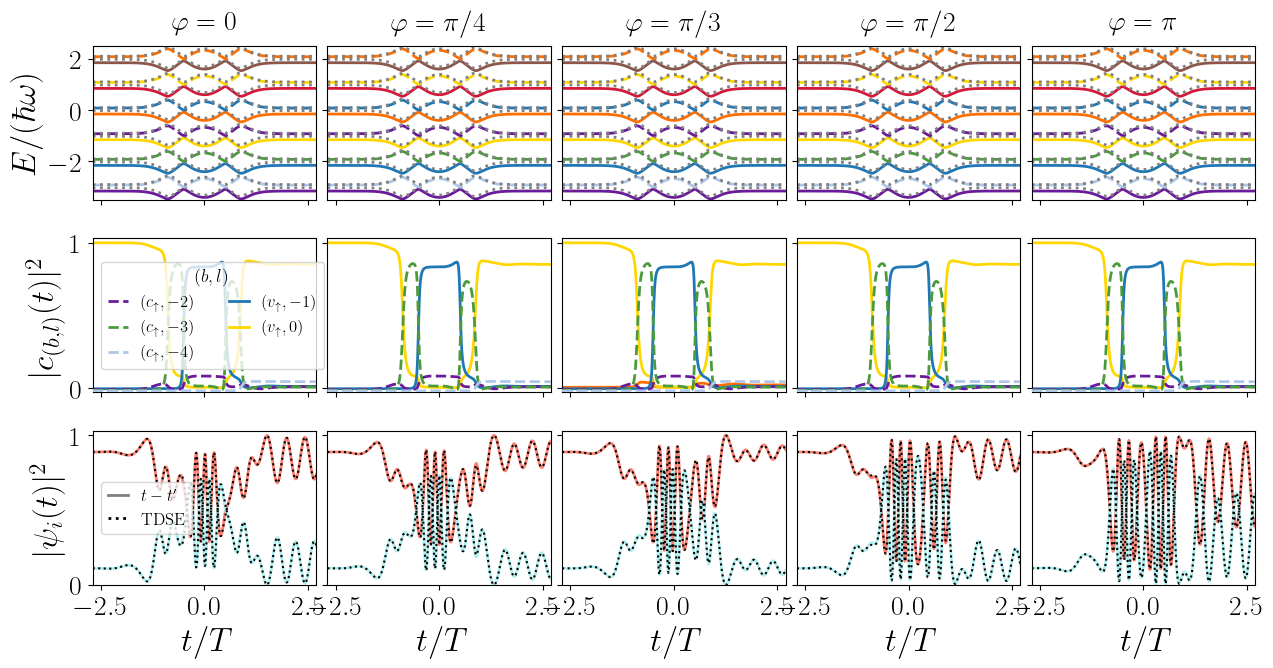

In [ ]:
data = np.load('FigsPaper/try_05_phis.npy', allow_pickle=True)

fig, axsall = plt.subplots(3,5, figsize=(15, 7), sharex=True, sharey='row', height_ratios=[2, 2, 2])
plt.subplots_adjust(hspace=0.25, wspace=0.05)

custom_colors = [
    '#7f7f7f',  '#aec7e8',  '#4B9B3D', '#6A1B9A', '#1F77B4', '#FFD700',
    '#FF6F00',  '#D4183A', '#8C564B', '#8C564B', '#9467BD',  '#E377C2',
    '#1F77B4',  '#BCBD22', '#98DF8A', '#FF9896'
]

cmap = mpl.colors.ListedColormap(custom_colors)
bounds = np.arange(-5.5, 10.6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

def format_label(b, l):
    spin = '\\uparrow' if b % 2 == 0 else '\\downarrow'
    state = 'v' if b in [0, 1] else 'c'
    return f'$({state}_{spin},{l})$'

lines = [Line2D([0], [0], color='k', linewidth=2, linestyle=ls) for ls in ['-', '--',':','-.']]
lab_lines = ['$b = 0$', '$b = 1$','$b = 2$', '$b = 3$']

linespsit = [Line2D([0], [0], color=c, linewidth=2, linestyle=ls) for c, ls in zip(['grey', 'k'], ['-', ':'])]
lab_linespsit = ['$t-t^\\prime$', 'TDSE'] 

first_plot = True

for axs, datai in zip(axsall.T, data):
    for cti, i in enumerate(datai['indexCbase']):
        l, m = datai['tagvec'][i]
        ls = ['-', ':', '--', ':'][int(l)]
        color = 'gray' if ls == ':' else cmap(norm(m))  
        label = format_label(int(l), int(m)) if (np.max(abs(datai['ct'][:, cti])) > 0.03) else None
        
        if np.max(datai['ct'][:, cti] ** 2) > 0.03:
            axs[1].plot(datai['ts_ct'] - 4, (np.abs(datai['ct'][:, cti]) ** 2) + 0.005 * m,
                        lw=2, c=color, zorder=-(m) + l, ls=ls, label=label)
        axs[0].plot(datai['ts'] - 4, datai['eL'][:, i], lw=2, c=color, ls=ls, label=label)

    axs[2].plot(datai['ts_ct'] - 4, np.abs(datai['psit'][:, 3]) ** 2, c='salmon', lw=2)
    axs[2].plot(datai['ts_ct'] - 4, np.abs(datai['psit'][:, 1]) ** 2, c='paleturquoise', lw=2)
    # Cambiar color de TDSE a gris
    axs[2].plot(datai['ts'] - 4, np.abs(datai['psiTDSE'][:, 3]) ** 2, ls=':', c='k') 
    axs[2].plot(datai['ts'] - 4, np.abs(datai['psiTDSE'][:, 1]) ** 2, ls=':', c='k') 

    if first_plot:
        axs[2].legend(linespsit, lab_linespsit, handlelength=1.2, fontsize=12, loc='center left')
        handles, labels = axs[1].get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        lg_col = axs[1].legend(handles, labels, fontsize=12, handlelength=1.2, ncols=2, loc='center left', title=r"$(b,l)$")
        lg_col.get_title().set_fontsize('13')
        first_plot = False 


for i, title in enumerate([r'$\varphi = 0 $', r'$\varphi = \pi/4 $', r'$\varphi = \pi/3 $',r'$\varphi = \pi/2 $',r'$\varphi = \pi $',]):
    axsall[0, i].set_title(title, y=1.05)

[ax.set(xlabel=r'$t/T$', xlim=(-4, 4)) for ax in axsall[-1]]

axsall[2, 0].set(ylabel=r'$|\psi_i(t)|^2$', xlabel='$t$', ylim=(0, 1.03))
axsall[0, 0].set(ylabel=r'$E/(\hbar \omega)$', xlabel='', ylim=(-3.5, 2.5), yticks=[-2,0, 2])
axsall[1, 0].set(ylabel=r'$|c_{(b,l)}(t)|^2$', xlabel='', ylim=(-0.03, 1.03))
[ax.set(xlabel=r'$t/T$', xlim=(-2.7, 2.7)) for ax in axsall[-1]]


fig.savefig('FigsPaper/Fig5_05_tauneg_more.svg', bbox_inches='tight', transparent=True)

plt.close()

fig


## Dichroism

In [5]:
def import_data(psi0band):
    def import_data_kx(kx):
        params_ham = {'k_x': kx, 'k_y': 0.0}
        name = folder0 + 'FigsPaper/{}/Ct_Ax{:.2f}_Ay{}_kx{:.4f}_ky{}.npz'.format(folderin,
            params_env['A_x'], params_env['A_y'], kx, params_ham['k_y'], )
        return np.load(name)
    data= []
    for kx in ks:
        datai= import_data_kx(kx)
        data.append({'tagvec':datai['tagvec'], 'indexCbase' : datai['indexCbase'],
                     'eL': datai['eL'], 'ct':datai['ct'][psi0band],
                     'psit': datai['psitsol'][psi0band]})
    ts = datai['ts']
    return ts, data

## Integrated values:
def lorentzian(x, x0, gamma):
    return (gamma / np.pi) / ((x[:, None] - x0[None, :]) ** 2 + gamma ** 2)

ts = np.linspace(1e-4, 7.1, 2200)
ks = np.arange(-2, 2, 0.05) + 1e-3  ## offset to avoid the numerical degenerancy at the DirP
Aval = 0.7
psi0band = 1

params_env = {'mu_sp': 3.5, 'tau_sp': 1., 'A_x': Aval, 'A_y': Aval, 'A_z': 0.}
tau_valley = -1 #-1, +1
folderin = 'Data_ifs' if tau_valley == +1 else 'Data_ifs_tauNeg'
ts, data = import_data(1)
params_ham = {'k_x': 0, 'k_y': 0.0, 'tau':tau_valley}
params_full = {**params_ham}

solver_dummy = IFS_solver(hTMDs_pulse, ts, params_env, params_full, Nmax = 6)

In [9]:
#### Computing of data

oms = np.linspace(-5,5,201)
gamma = 0.2
AlistL = solver_dummy.Alist[:,0]
t_sel = [[0], np.where(AlistL > 1e-3)[0]]

for tau_valley in [-1, 1]:
    folderin = 'Data_ifs' if tau_valley == 1 else 'Data_ifs_tauNeg'
    all_bands_sum_all = []
    all_bands_sum_0 = []
    
    for band in range(4):
        ts, data = import_data(band)
        ct_k = np.array([d['ct'] for d in data])
        tensor_total = []
        
        for t_group in t_sel:
            for ti in t_group:
                eL = np.array([d['eL'][ti] for d in data])
                indexCbase_k = np.array([d['indexCbase'] for d in data])
                col_k = (np.abs(ct_k[:,ti])**2)[:,:indexCbase_k.shape[1]]
                ensL = np.array([eL[k][idx] for k, idx in enumerate(indexCbase_k)])
                
                contribs = [np.multiply(lorentzian(oms, ensL[k], gamma), col_k[k]) 
                            for k in range(len(data))]
                tensor_total.append(contribs)
        
        tensor_total = np.array(tensor_total)
        sum_all = tensor_total.sum(axis=(0,1,3))
        sum_0 = tensor_total[0].sum(axis=(0,2)) 
        
        all_bands_sum_all.append(sum_all)
        all_bands_sum_0.append(sum_0)
    
    np.savez(folder0+'FigsPaper/'+f'data_tau_{tau_valley}_00.npz',
         sum_all=all_bands_sum_all,
         sum_0=all_bands_sum_0,
         oms=oms,
         gamma=gamma)

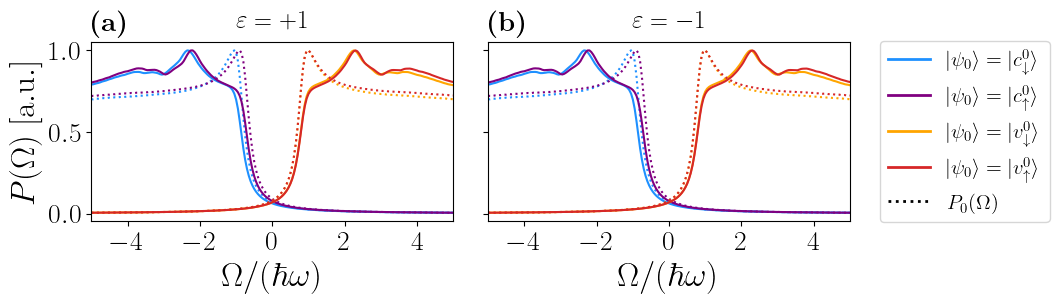

In [ ]:
plt.close()

tau_values = [1, -1]
colors_1 = ['dodgerblue', 'purple', 'orange', 'tab:red']
colors_neg1 = ['dodgerblue', 'purple', 'orange', 'tab:red']
styles = {1: '-', -1: '-'}
dos_style = ':' 

color_labels = {
    'dodgerblue': r'$\psi_0 = c_\downarrow$',
    'purple': r'$\psi_0 = c_\uparrow$',
    'orange': r'$\psi_0 = v_\downarrow$',
    'tab:red': r'$\psi_0 = v_\uparrow$' }

fig, axs = plt.subplots(1, 2, figsize=(4.5*2, 3.5), sharey=True)
added_labels = set() 

for i, tau in enumerate(tau_values):
    ax = axs[i]
    data = np.load(folder0+'FigsPaper/'+f'data_tau_{tau_valley}_00.npz')
    oms = data['oms']
    
    for band_idx in range(4):
        color = colors_1[band_idx] if tau == 1 else colors_neg1[band_idx]
        
        sum_all = data['sum_all'][band_idx]
        sum_0 = data['sum_0'][band_idx]
        norm_all = sum_all / sum_all.max()
        norm_dos = sum_0 / sum_0.max()
        
        label_main = color_labels[color] if color not in added_labels else None
        line_main, = ax.plot(oms, norm_all, color=color, ls=styles[tau], label=label_main)
        if label_main: added_labels.add(color)
        
        ax.plot(oms, norm_dos, color=color, ls=dos_style, label='' if band_idx > 0 else '_nolegend_')

    
    ax.set(xlabel=r'$\Omega/(\hbar \omega)$', xlim=(-5,5), xticks=np.arange(-4,6,2))
    if i == 0: ax.set(ylabel=r'$P(\Omega) \; \mathrm{[a.u.]}$')

legend_elements = [
    plt.Line2D([0], [0], color='dodgerblue', lw=2, label=r'$| \psi_0  \rangle = | c_\downarrow^0\rangle$'),
    plt.Line2D([0], [0], color='purple', lw=2, label=r'$|\psi_0 \rangle= | c_\uparrow^0\rangle$'),
    plt.Line2D([0], [0], color='orange', lw=2, label=r'$|\psi_0 \rangle= | v_\downarrow^0\rangle$'),
    plt.Line2D([0], [0], color='tab:red', lw=2, label=r'$|\psi_0 \rangle= | v_\uparrow^0\rangle$'),
    plt.Line2D([0], [0], color='black', ls=':', lw=2, label=r'$P_0(\Omega)$') ]

axs[0].set_title(r'$\varepsilon = +1$', fontsize=18, pad=10)
axs[1].set_title(r'$\varepsilon = -1$', fontsize=18, pad=10)
fig.legend(handles=legend_elements, 
           bbox_to_anchor=(1.2, 0.55), 
           loc='center right',
           fontsize=15)

createletters(axs.ravel(), coord=[0.0, 1.065])
plt.tight_layout()
plt.show()

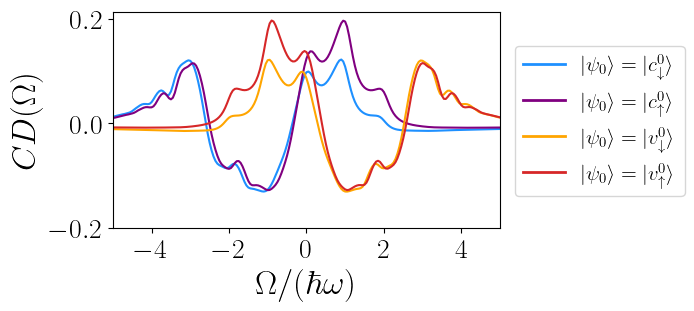

In [14]:
data_pos = np.load(folder0 + 'FigsPaper/' +'data_tau_1_00.npz')
data_neg = np.load(folder0 + 'FigsPaper/' +'data_tau_-1_00.npz')
oms = data_pos['oms']

fig, ax = plt.subplots(figsize=(5.5,3.5))
colors = ['dodgerblue', 'purple', 'orange', 'tab:red']

for band in range(4):
    pos = data_pos['sum_all'][band]/np.sum(data_pos['sum_all'][band])
    neg = data_neg['sum_all'][band]/np.sum(data_neg['sum_all'][band])
    diff = (pos-neg)/(pos+neg)
    
    ax.plot(oms, diff, 
            color=colors[band])

ax.set(ylabel=r'$CD (\Omega)$', xlabel=r'$\Omega/(\hbar \omega)$',
       xlim=(-5,5), xticks=np.arange(-4,6,2), yticks=[-0.2,0,0.2])

legend_elements = [
    plt.Line2D([0], [0], color='dodgerblue', lw=2, label=r'$| \psi_0  \rangle = | c_\downarrow^0\rangle$'),
    plt.Line2D([0], [0], color='purple', lw=2, label=r'$|\psi_0 \rangle= | c_\uparrow^0\rangle$'),
    plt.Line2D([0], [0], color='orange', lw=2, label=r'$|\psi_0 \rangle= | v_\downarrow^0\rangle$'),
    plt.Line2D([0], [0], color='tab:red', lw=2, label=r'$|\psi_0 \rangle= | v_\uparrow^0\rangle$')
]


fig.legend(handles=legend_elements, 
           bbox_to_anchor=(1.3, 0.6), 
           loc='center right',
           fontsize=15)
plt.tight_layout()
plt.show()